In [78]:
import pandas as pd
MAX_PROTON_FRACTIONS = 15
BED = pd.read_csv('../proton/data/PayoffMatrix_fake.txt', sep='   ', names=[str(i) + '_prots' for i in range(0,MAX_PROTON_FRACTIONS+1)])
BED_vals = BED.values
patient_num = BED.shape[0]

C:\Users\azika\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [79]:
import sys
sys.path.append('../proton/')
from estimator import LinearBEDPredictor, BEDPredictorUpperBoundNaive, BEDPredictorUpperBoundCorrect

In [80]:
gran = 4
BED_min = pd.DataFrame(LinearBEDPredictor(BED_vals).estimate(granularity=gran))
BED_max_nondecrease = pd.DataFrame(BEDPredictorUpperBoundNaive(BED_vals).estimate(granularity=gran))
BED_max_concave = pd.DataFrame(BEDPredictorUpperBoundCorrect(BED_vals).estimate(granularity=gran))
interp_step = MAX_PROTON_FRACTIONS / (gran - 1)  # take out -1
looked_up_inds = [int(i * interp_step) for i in range(gran)]

In [81]:
17%6

5

range(0, 33)
12


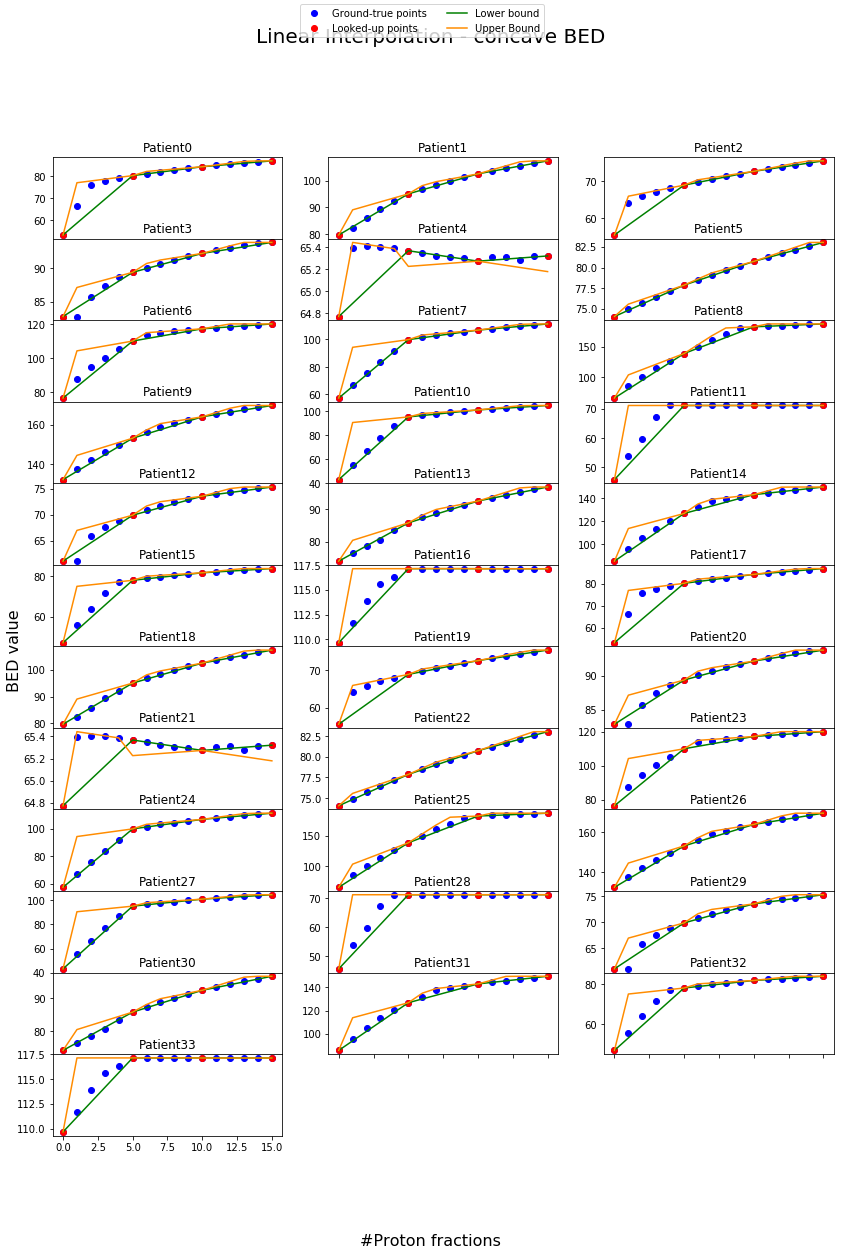

In [97]:
import itertools
import math
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyles = ['_', '-', '--', ':']
color_styles = list(itertools.product(colors,linestyles))
print(range(0,patient_num-1))


def plot_patients(absolute, BED, BED_min, BED_max, looked_up_inds, title):
    Y_plots = 3 # plots per row
    X_plots = math.ceil((patient_num) / Y_plots)
    print(X_plots)
    plot_objs = []
    if absolute:
        fig, axarr = plt.subplots(X_plots, Y_plots, sharex=True, sharey=True) #sharex='col', sharey='row'
    else:
        fig, axarr = plt.subplots(X_plots, Y_plots, sharex=True) #sharex='col', sharey='row'
    for i in range(0,patient_num):
        x,y = math.floor(i / Y_plots), i % Y_plots
        BED_looked_up = BED[looked_up_inds]
        
        obj1, = axarr[x,y].plot(range(0,MAX_PROTON_FRACTIONS+1), BED.loc[i,], 'bo')
        obj2, = axarr[x,y].plot(looked_up_inds, BED_looked_up.loc[i, ], 'ro')
        obj3, = axarr[x,y].plot(range(0,MAX_PROTON_FRACTIONS+1), BED_min.loc[i,], color = 'g')#''.join(color_styles[i])
        obj4, = axarr[x,y].plot(range(0,MAX_PROTON_FRACTIONS+1), BED_max.loc[i,], color = 'darkorange')#''.join(color_styles[i])        
        axarr[x,y].set_title('Patient' + str(i))
    for i in range(0, Y_plots - (patient_num % Y_plots)):
        axarr[-1, -(i+1)].axis('off') #hidding plots that are not used
    plot_objs = [obj1, obj2, obj3, obj4]
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(title, fontsize=20)
    #fig.set_size_inches(18.5, 8)
    fig.set_size_inches(14, 18)
    #fig.legend((line,line), ('Upper Bound','aa'), 'upper right')
    fig.legend(plot_objs, ('Ground-true points','Looked-up points', 'Lower bound', 'Upper Bound'), loc = 'upper center', ncol=2)
    fig.text(0.5, 0.04, '#Proton fractions', ha='center', fontsize=16)
    fig.text(0.08, 0.5, 'BED value', va='center', rotation='vertical', fontsize=16)
    plt.show() 
#plot_patients(False, BED, BED_min, BED_max_nondecrease, looked_up_inds, title = "Linear Interpolation - nondecreasing BED")
plot_patients(False, BED, BED_min, BED_max_concave, looked_up_inds, title = "Linear Interpolation - concave BED")

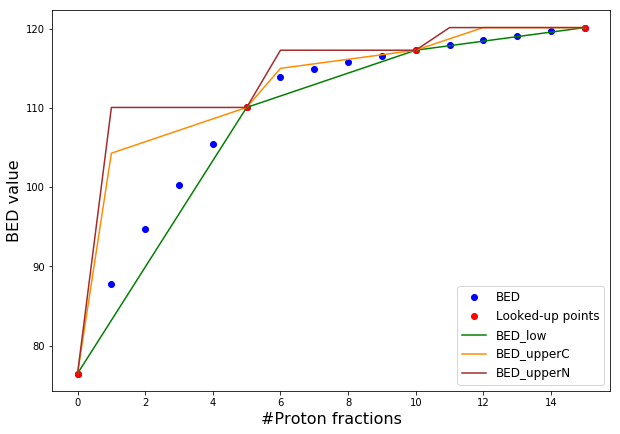

In [83]:
#plotting one patient 
def plot_one_patient( BED, BED_min, BED_max, BED_max2, looked_up_inds, title):
    plot_objs = []
    plt.figure(figsize=(10,7))
    BED_looked_up = BED[looked_up_inds]
    i = 6
    obj1, = plt.plot(range(0,MAX_PROTON_FRACTIONS+1), BED.loc[i,], 'bo')
    obj2, = plt.plot(looked_up_inds, BED_looked_up.loc[i, ], 'ro')
    obj3, = plt.plot(range(0,MAX_PROTON_FRACTIONS+1), BED_min.loc[i,], color = 'g')#''.join(color_styles[i])
    obj4, = plt.plot(range(0,MAX_PROTON_FRACTIONS+1), BED_max.loc[i,], color = 'darkorange')#''.join(color_styles[i])        
    obj5, = plt.plot(range(0,MAX_PROTON_FRACTIONS+1), BED_max2.loc[i,], color = 'brown')#''.join(color_styles[i])        
    plot_objs = [obj1, obj2, obj3, obj4, obj5]
    #plt.title("P")
    plt.legend(plot_objs, ('BED','Looked-up points', 'BED_low', 'BED_upperC', 'BED_upperN'), fontsize=12)
    plt.xlabel('#Proton fractions', fontsize=16)
    plt.ylabel('BED value', fontsize=16)
    plt.show()
plot_one_patient(BED, BED_min, BED_max_concave, BED_max_nondecrease, looked_up_inds, title = "Linear Interpolation - concave BED")

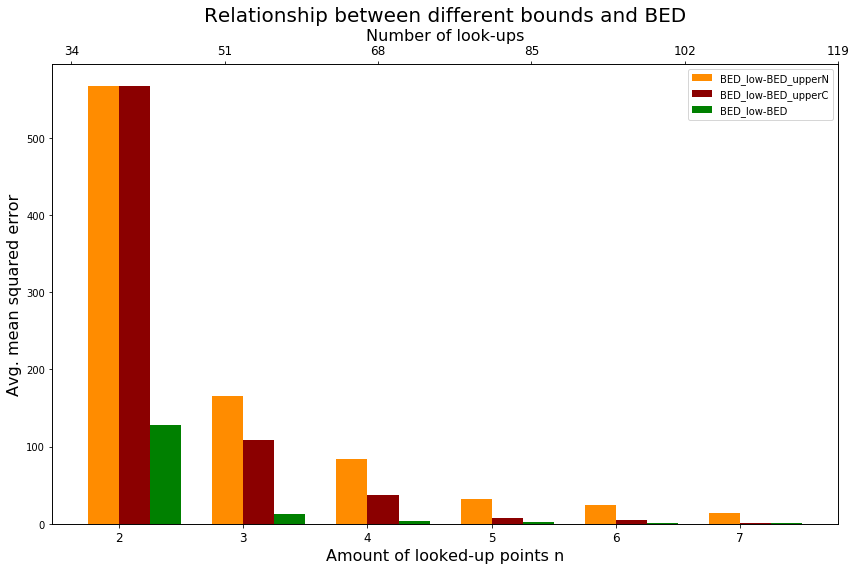

In [125]:
#mean square error plotting
import matplotlib.pyplot as plt
import numpy as np
def avg_mean_squared_err(BED1, BED2):
    return np.sum(np.sum((BED1 - BED2)**2)) / (BED1.shape[0] * BED1.shape[1])

gran_range = range(2, 8)
error_true_low = []
error_low_upper_c = []
error_low_upper_nd = []
for gran in gran_range:
    BED_min = pd.DataFrame(LinearBEDPredictor(BED_vals).estimate(granularity=gran))
    BED_max_nondecrease = pd.DataFrame(BEDPredictorUpperBoundNaive(BED_vals).estimate(granularity=gran))
    BED_max_concave = pd.DataFrame(BEDPredictorUpperBoundCorrect(BED_vals).estimate(granularity=gran))
    error_true_low.append(avg_mean_squared_err(BED_vals, BED_min))
    error_low_upper_c.append(avg_mean_squared_err(BED_min, BED_max_concave))
    error_low_upper_nd.append(avg_mean_squared_err(BED_min, BED_max_nondecrease))
    
fig, ax1 = plt.subplots()

fig.set_size_inches(12, 8)
index = np.arange(len(error_true_low))
bar_width = 0.25

rects3 = plt.bar(index, error_low_upper_nd, bar_width,
                 label='BED_low-BED_upperN', color = 'darkorange')

rects2 = plt.bar(index + bar_width, error_low_upper_c, bar_width,
                 label='BED_low-BED_upperC', color = 'darkred')

rects1 = plt.bar(index + bar_width + bar_width, error_true_low, bar_width,
                 label='BED_low-BED',color ='g')


plt.xlabel('Amount of looked-up points n', fontsize=16)
plt.ylabel('Avg. mean squared error', fontsize=16)
plt.title('Relationship between different bounds and BED', fontsize=20, y=1.08)
plt.xticks(index + bar_width / 2, gran_range, fontsize = 12)

plt.legend()

ax2 = ax1.twiny()
ax2.set_xlabel('Number of look-ups', fontsize=16)
#ax2.plot(index * 17, -index-2, 'w.')
ax2.set_xticks(index + bar_width / 2, minor=False)
ax2.set_xticklabels(np.array(gran_range) * (MAX_PROTON_FRACTIONS+1), fontsize = 12)
#ax2.tick_params('y', colors='r')



plt.tight_layout()
plt.show()
#BED_max_nondecrease

In [121]:
np.array(gran_range) * 17

array([ 34,  51,  68,  85, 102, 119])

In [38]:
error_true_low

[127.56454373795187,
 12.997260702810639,
 3.392616300927266,
 1.7172891046063723,
 0.8862204761867156,
 0.46824835962798506]

In [ ]:
#convex interpolation
from scipy.interpolate import interp1d
import numpy as np

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()
x